In [77]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import AutoEncoderCIFAR, EncoderCIFAR
from main import Autoencoder
from torch.utils.data import Dataset, DataLoader, random_split

ImportError: cannot import name 'EncoderCIFAR' from 'AutoEncoderDecoder' (/Users/mayanrivlin/Documents/Technion/Sem1/Deep learning on computation 02360781/deep_learning_project/code/AutoEncoderDecoder.py)

In [58]:
# Argument parser for command-line arguments
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=0, type=int, help='Seed for random number generators')
    parser.add_argument('--data-path', default="~/datasets/cv_datasets/data", type=str, help='Path to dataset')
    parser.add_argument('--batch-size', default=8, type=int, help='Size of each batch')
    parser.add_argument('--latent-dim', default=128, type=int, help='Encoding dimension')
    parser.add_argument('--device', default='cuda' if torch.cuda.is_available() else 'cpu', type=str, help='Default device to use')
    parser.add_argument('--mnist', action='store_true', default=False, help='Use MNIST (True) or CIFAR10 (False) data')
    parser.add_argument('--self-supervised', action='store_true', default=False, help='Train self-supervised or jointly with classifier')
    parser.add_argument('--debug', action='store_true', default=False, help='Enable debugging for dataloader')
    args, unknown =  parser.parse_args()
    return args

NUM_CLASSES = 10

In [59]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [60]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [61]:
freeze_seeds(0)

In [62]:
import os
current_dir = os.getcwd()
train_dataset = datasets.CIFAR10(root=current_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=current_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Function to rescale images back from [-1, 1] to [0, 1]
def rescale_image(image):
    return np.clip((image + 1) / 2, 0, 1)  # Rescale from [-1, 1] to [0, 1]

# Function to plot reconstructed images (rescale after reconstruction)
def plot_reconstruction(original, reconstructed, num_images=10):
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()
    
    # Rescale images to [0, 1] range for visualization
    original = rescale_image(original)
    reconstructed = rescale_image(reconstructed)
    num_images = min(num_images, original.shape[0])  # Ensure we don't exceed batch size
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

    for i in range(num_images):
        ax = axes[i, 0]
        ax.imshow(np.transpose(original[i], (1, 2, 0)))  # Reorder dimensions to (H, W, C)
        ax.set_title('Original')
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        ax.set_title('Reconstructed')
        ax.axis('off')

    plt.show()
    

Epoch 1, Loss: 0.06744948597252369


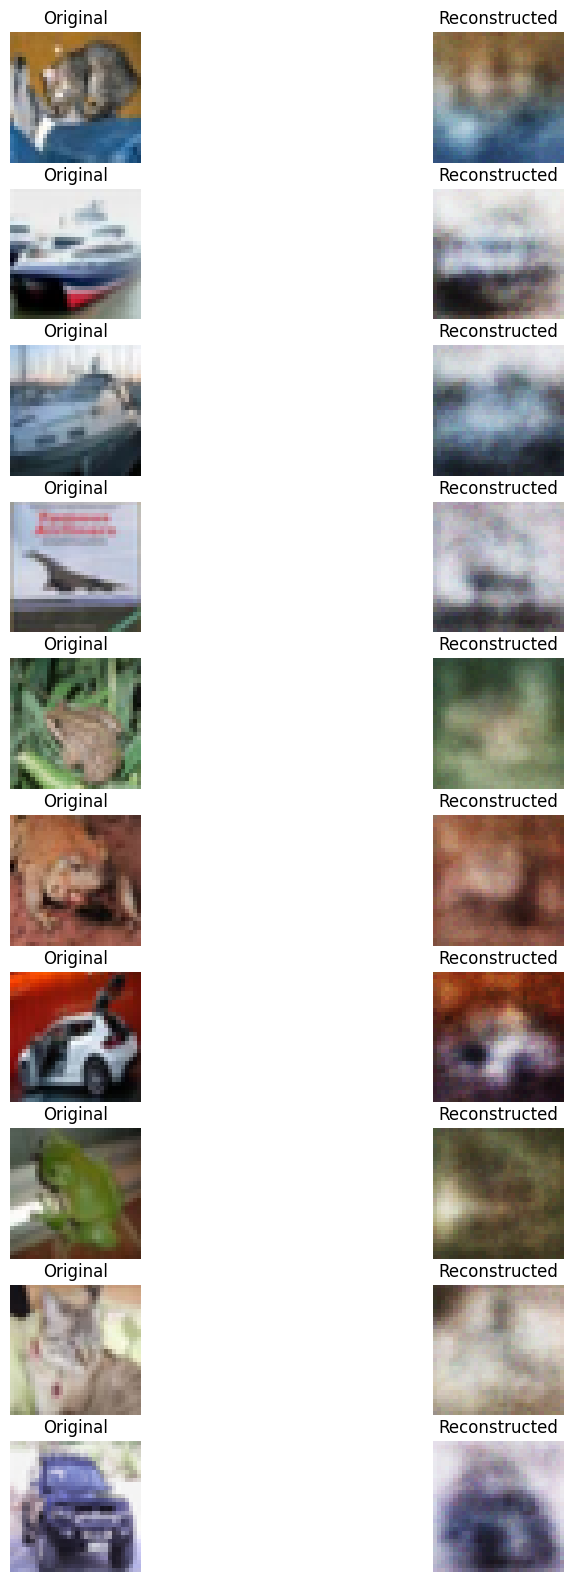

In [65]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader 
dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

im_size = train_dataset[0][0].shape

# Initialize the autoencoder and the optimizer
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(latent_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop for self-supervised task
num_epochs = 1
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in dl_train:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, _ = autoencoder(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dl_train)  # Average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")

    # Plot reconstructions after training
    with torch.no_grad():
        test_images, _ = next(iter(dl_test))
        test_images = test_images.to(device)
        reconstructed, _ = autoencoder(test_images)
        plot_reconstruction(test_images, reconstructed)



batch_images, _ = next(iter(dl_train))  # Get one batch of images
batch_images    = batch_images.to(device)  # Move to GPU if available



In [ ]:
#### Classifier Model ###

# class Classifier(torch.nn.Module):
#     def __init__(self, latent_dim, num_classes):
#         super(Classifier, self).__init__()
#         self.fc = torch.nn.Linear(latent_dim, num_classes)  

#     def forward(self, x):
#         return self.fc(x)  


class Classifier(torch.nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = torch.nn.Linear(latent_dim, 512)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(512, num_classes)  # Final output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Hidden layer with ReLU
        return self.fc2(x)  # Output layer for classification



In [75]:
for param in autoencoder.encoder.parameters(): # Freeze encoder weights
    param.requires_grad = False

In [76]:
# Initialize the classifier and optimizer
classifier = Classifier(latent_dim, NUM_CLASSES).to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion_classifier = torch.nn.CrossEntropyLoss()

# Training loop for classifier
num_epochs = 10  
for epoch in range(num_epochs):
    classifier.train()  # training mode
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in dl_train:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Get latent representation from the encoder 
        with torch.no_grad():
            latent = autoencoder.encoder(images)

        classifier_optimizer.zero_grad() 
        outputs = classifier(latent) 

        loss = criterion_classifier(outputs, labels)  # Cross-Entropy Loss
        loss.backward()  # Backpropagate
        classifier_optimizer.step()  # Update classifier weights

        epoch_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(dl_train)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.6333, Accuracy: 42.19%
Epoch 2, Loss: 1.4187, Accuracy: 49.88%
Epoch 3, Loss: 1.3153, Accuracy: 53.40%
Epoch 4, Loss: 1.2371, Accuracy: 56.34%
Epoch 5, Loss: 1.1679, Accuracy: 58.65%
Epoch 6, Loss: 1.1053, Accuracy: 61.03%
Epoch 7, Loss: 1.0474, Accuracy: 62.87%
Epoch 8, Loss: 0.9975, Accuracy: 64.78%
Epoch 9, Loss: 0.9505, Accuracy: 66.23%
Epoch 10, Loss: 0.9030, Accuracy: 68.01%


In [73]:
# Test the classifier on the test set
classifier.eval()  # Set classifier to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in dl_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        latent = autoencoder.encoder(images)
        outputs = classifier(latent)

        # Calculate loss
        loss = criterion_classifier(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(dl_test):.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


Test Loss: 1.6970
Test Accuracy: 40.42%


In [ ]:
###Classification-Guided Encoding###

